# Big Mart Sales: Practice Problem

In [1]:
library(data.table)
library(dplyr)
library(ggplot2)
library(caret)
library(corrplot)
library(e1071)
library(xgboost)
library(cowplot)

Warning message:
"package 'data.table' was built under R version 3.6.3"Warning message:
"package 'dplyr' was built under R version 3.6.3"
Attaching package: 'dplyr'

The following objects are masked from 'package:data.table':

    between, first, last

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Warning message:
"package 'ggplot2' was built under R version 3.6.3"Warning message:
"package 'caret' was built under R version 3.6.3"Loading required package: lattice
Warning message:
"package 'lattice' was built under R version 3.6.3"Warning message:
"package 'corrplot' was built under R version 3.6.3"corrplot 0.88 loaded
Warning message:
"package 'e1071' was built under R version 3.6.3"Warning message:
"package 'xgboost' was built under R version 3.6.3"
Attaching package: 'xgboost'

The following object is masked from 'package:dplyr':

    slice

Warning message:
"pack

In [2]:
train = fread("Train_UWu5bXk.csv")
test = fread("Test_u94Q5KV.csv")
submission = fread("SampleSubmission_TmnO39y.csv")

In [3]:
names(train)

[1] "Item_Identifier"           "Item_Weight"              
 [3] "Item_Fat_Content"          "Item_Visibility"          
 [5] "Item_Type"                 "Item_MRP"                 
 [7] "Outlet_Identifier"         "Outlet_Establishment_Year"
 [9] "Outlet_Size"               "Outlet_Location_Type"     
[11] "Outlet_Type"               "Item_Outlet_Sales"

In [4]:
names(test)

[1] "Item_Identifier"           "Item_Weight"              
 [3] "Item_Fat_Content"          "Item_Visibility"          
 [5] "Item_Type"                 "Item_MRP"                 
 [7] "Outlet_Identifier"         "Outlet_Establishment_Year"
 [9] "Outlet_Size"               "Outlet_Location_Type"     
[11] "Outlet_Type"

In [5]:
str(train)

Classes 'data.table' and 'data.frame':	8523 obs. of  12 variables:
 $ Item_Identifier          : chr  "FDA15" "DRC01" "FDN15" "FDX07" ...
 $ Item_Weight              : num  9.3 5.92 17.5 19.2 8.93 ...
 $ Item_Fat_Content         : chr  "Low Fat" "Regular" "Low Fat" "Regular" ...
 $ Item_Visibility          : num  0.016 0.0193 0.0168 0 0 ...
 $ Item_Type                : chr  "Dairy" "Soft Drinks" "Meat" "Fruits and Vegetables" ...
 $ Item_MRP                 : num  249.8 48.3 141.6 182.1 53.9 ...
 $ Outlet_Identifier        : chr  "OUT049" "OUT018" "OUT049" "OUT010" ...
 $ Outlet_Establishment_Year: int  1999 2009 1999 1998 1987 2009 1987 1985 2002 2007 ...
 $ Outlet_Size              : chr  "Medium" "Medium" "Medium" "" ...
 $ Outlet_Location_Type     : chr  "Tier 1" "Tier 3" "Tier 1" "Tier 3" ...
 $ Outlet_Type              : chr  "Supermarket Type1" "Supermarket Type2" "Supermarket Type1" "Grocery Store" ...
 $ Item_Outlet_Sales        : num  3735 443 2097 732 995 ...
 - attr(*, ".i

In [6]:
str(test)

Classes 'data.table' and 'data.frame':	5681 obs. of  11 variables:
 $ Item_Identifier          : chr  "FDW58" "FDW14" "NCN55" "FDQ58" ...
 $ Item_Weight              : num  20.75 8.3 14.6 7.32 NA ...
 $ Item_Fat_Content         : chr  "Low Fat" "reg" "Low Fat" "Low Fat" ...
 $ Item_Visibility          : num  0.00756 0.03843 0.09957 0.01539 0.1186 ...
 $ Item_Type                : chr  "Snack Foods" "Dairy" "Others" "Snack Foods" ...
 $ Item_MRP                 : num  107.9 87.3 241.8 155 234.2 ...
 $ Outlet_Identifier        : chr  "OUT049" "OUT017" "OUT010" "OUT017" ...
 $ Outlet_Establishment_Year: int  1999 2007 1998 2007 1985 1997 2009 1985 2002 2007 ...
 $ Outlet_Size              : chr  "Medium" "" "" "" ...
 $ Outlet_Location_Type     : chr  "Tier 1" "Tier 2" "Tier 3" "Tier 2" ...
 $ Outlet_Type              : chr  "Supermarket Type1" "Supermarket Type1" "Grocery Store" "Supermarket Type1" ...
 - attr(*, ".internal.selfref")=<externalptr> 


In [7]:
dim(train);dim(test)

[1] 8523   12

[1] 5681   11

In [8]:
test[,Item_Outlet_Sales := NA]
combi = rbind(train, test) # combining train and test datasets
dim(combi)

[1] 14204    12

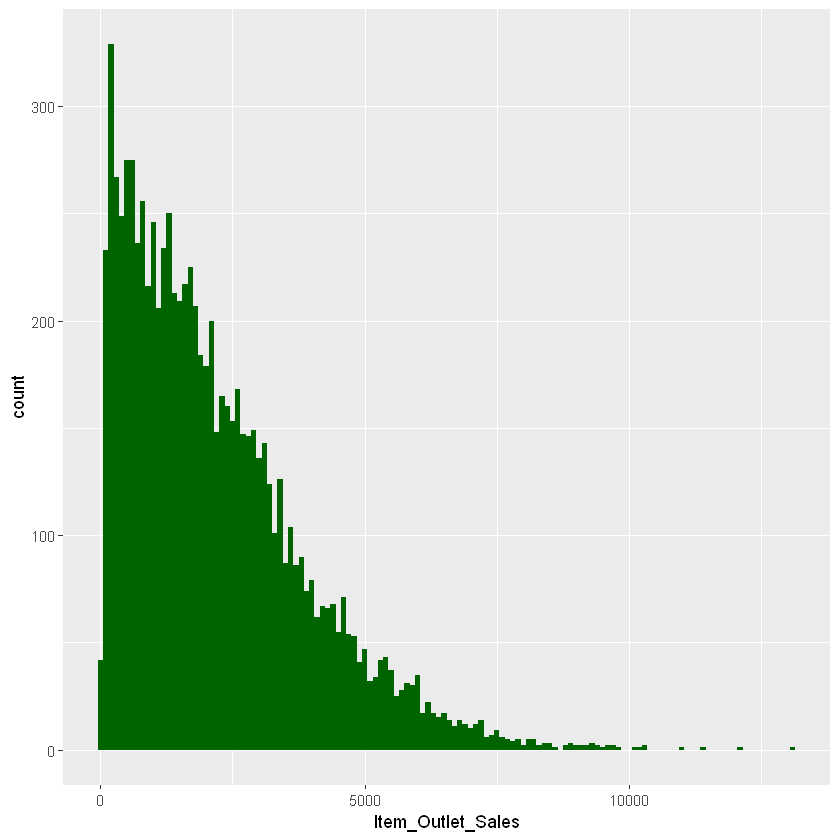

In [9]:
ggplot(train) + geom_histogram(aes(train$Item_Outlet_Sales), binwidth = 100, fill = "darkgreen") +xlab("Item_Outlet_Sales")

Warning message:
"Removed 2439 rows containing non-finite values (stat_bin)."

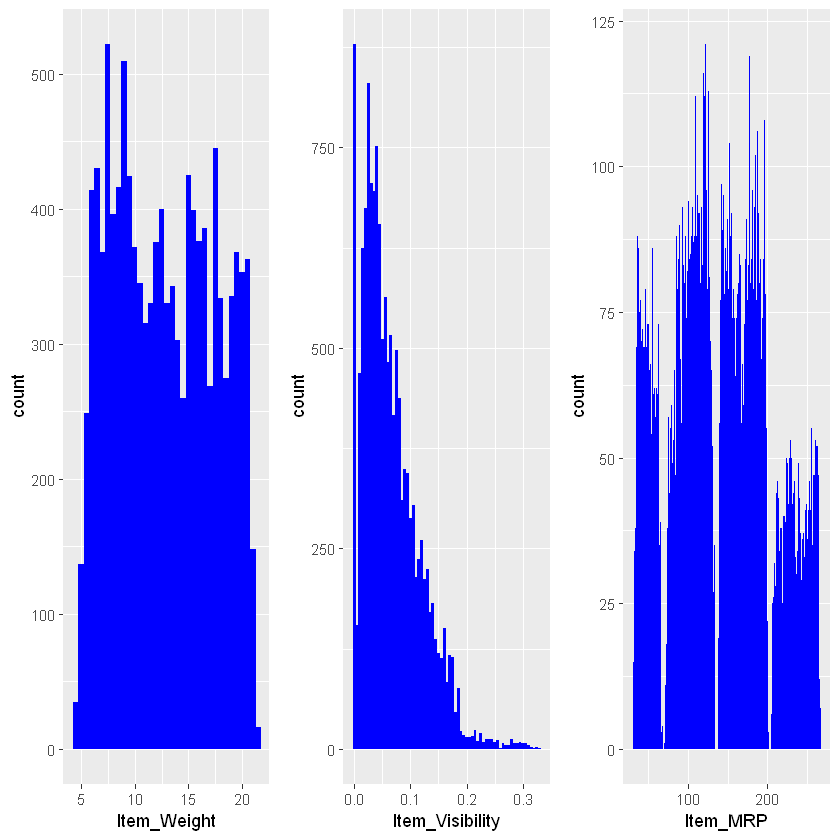

In [10]:
p1 = ggplot(combi) + geom_histogram(aes(Item_Weight), binwidth = 0.5, fill = "blue")
p2 = ggplot(combi) + geom_histogram(aes(Item_Visibility), binwidth = 0.005, fill = "blue")
p3 = ggplot(combi) + geom_histogram(aes(Item_MRP), binwidth = 1, fill = "blue")
plot_grid(p1, p2, p3, nrow = 1) # plot_grid() from cowplot package

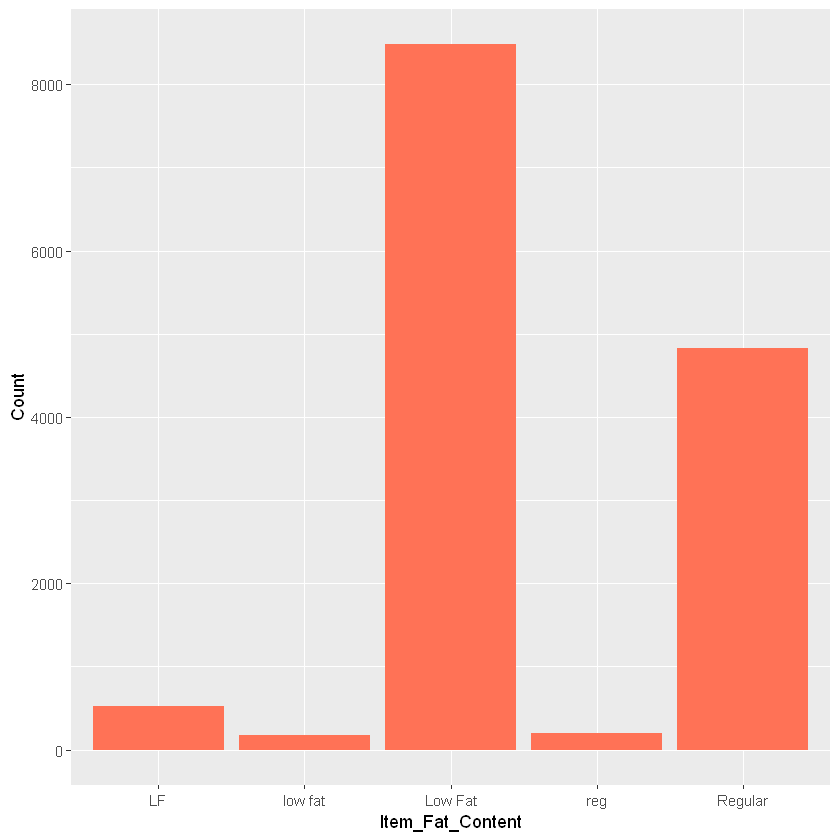

In [11]:
ggplot(combi %>% group_by(Item_Fat_Content) %>% summarise(Count = n())) + 
  geom_bar(aes(Item_Fat_Content, Count), stat = "identity", fill = "coral1")

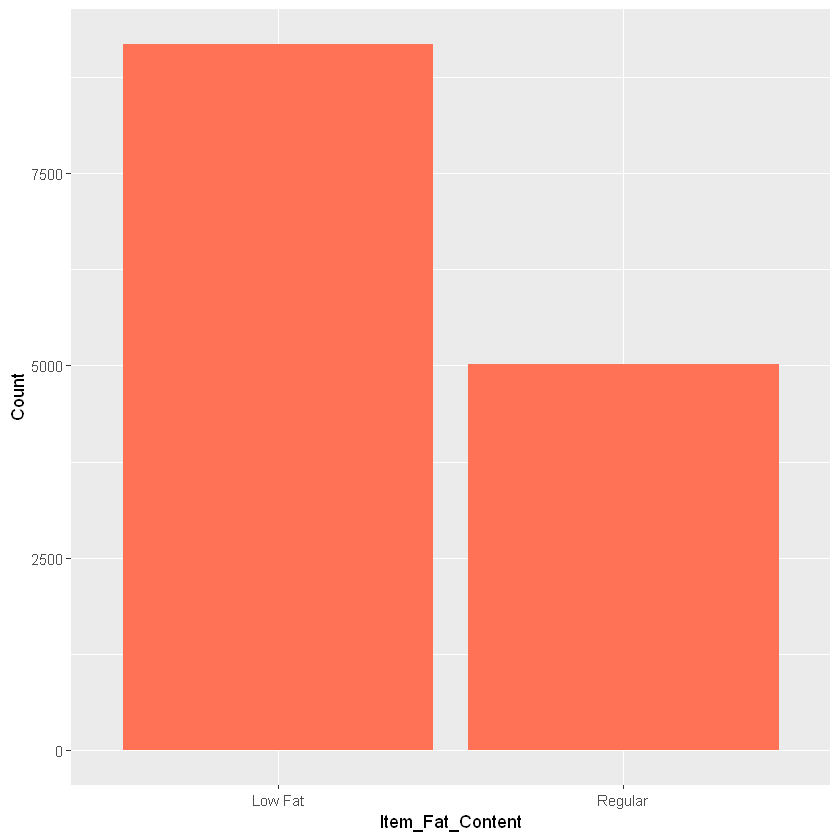

In [13]:
combi$Item_Fat_Content[combi$Item_Fat_Content == "LF"] = "Low Fat"
combi$Item_Fat_Content[combi$Item_Fat_Content == "low fat"] = "Low Fat"
combi$Item_Fat_Content[combi$Item_Fat_Content == "reg"] = "Regular"
ggplot(combi %>% group_by(Item_Fat_Content) %>% summarise(Count = n())) + 
  geom_bar(aes(Item_Fat_Content, Count), stat = "identity", fill = "coral1")

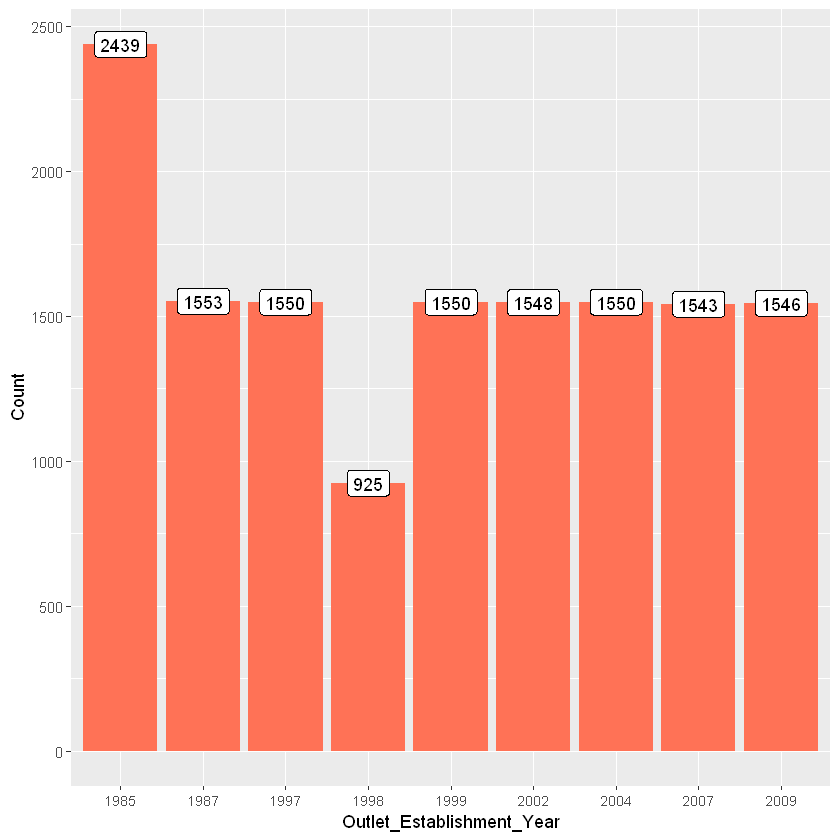

In [14]:
# plot for Outlet_Establishment_Year
p7 = ggplot(combi %>% group_by(Outlet_Establishment_Year) %>% summarise(Count = n())) + 
  geom_bar(aes(factor(Outlet_Establishment_Year), Count), stat = "identity", fill = "coral1") +
  geom_label(aes(factor(Outlet_Establishment_Year), Count, label = Count), vjust = 0.5) +
  xlab("Outlet_Establishment_Year") +
  theme(axis.text.x = element_text(size = 8.5))
 
p7

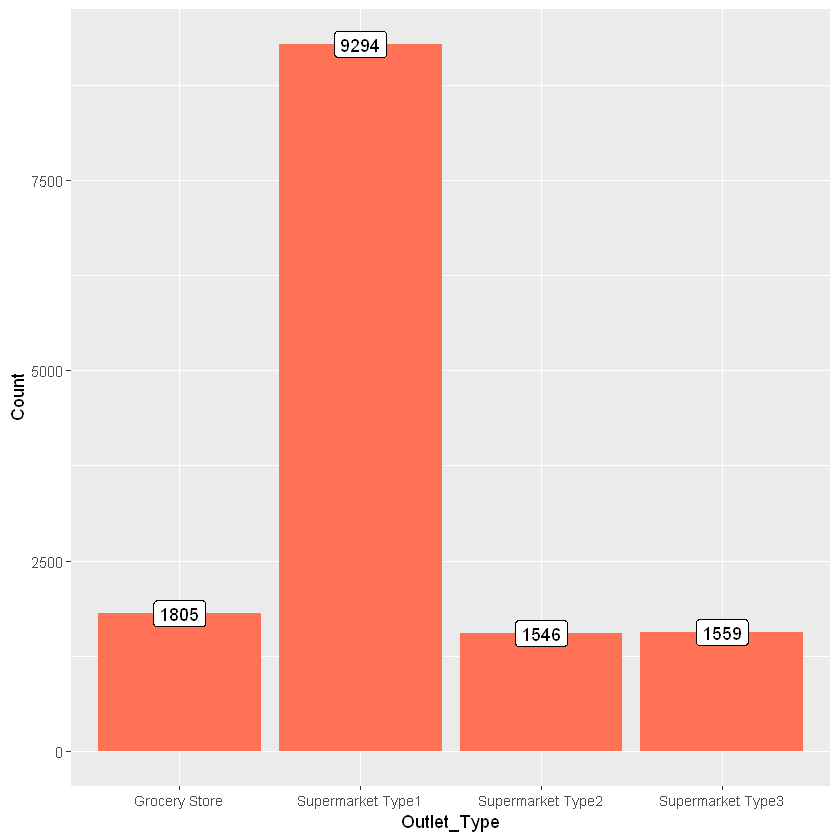

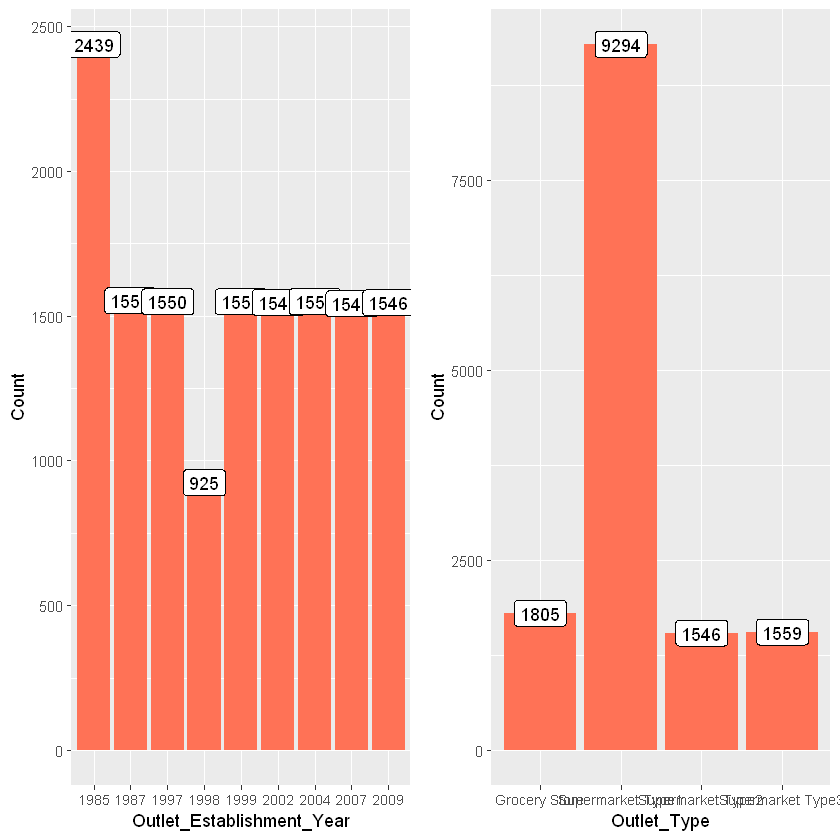

In [15]:
# plot for Outlet_Type
p8 = ggplot(combi %>% group_by(Outlet_Type) %>% summarise(Count = n())) + 
  geom_bar(aes(Outlet_Type, Count), stat = "identity", fill = "coral1") +
  geom_label(aes(factor(Outlet_Type), Count, label = Count), vjust = 0.5) +
  theme(axis.text.x = element_text(size = 8.5))
 
p8
 
# ploting both plots together
plot_grid(p7, p8, ncol = 2)

Warning message:
"Removed 1463 rows containing missing values (geom_point)."

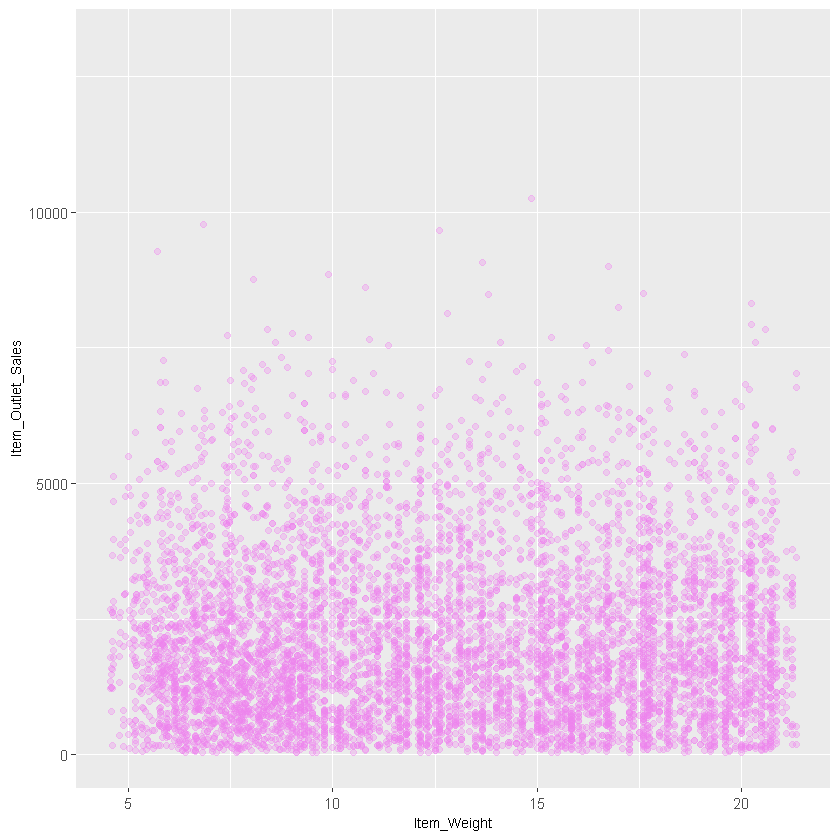

In [18]:
train=combi[1:nrow(train)]
p9 = ggplot(train) + geom_point(aes(Item_Weight, Item_Outlet_Sales), color = "violet", alpha=0.3)+theme(axis.title = element_text(size=8.5))
p9

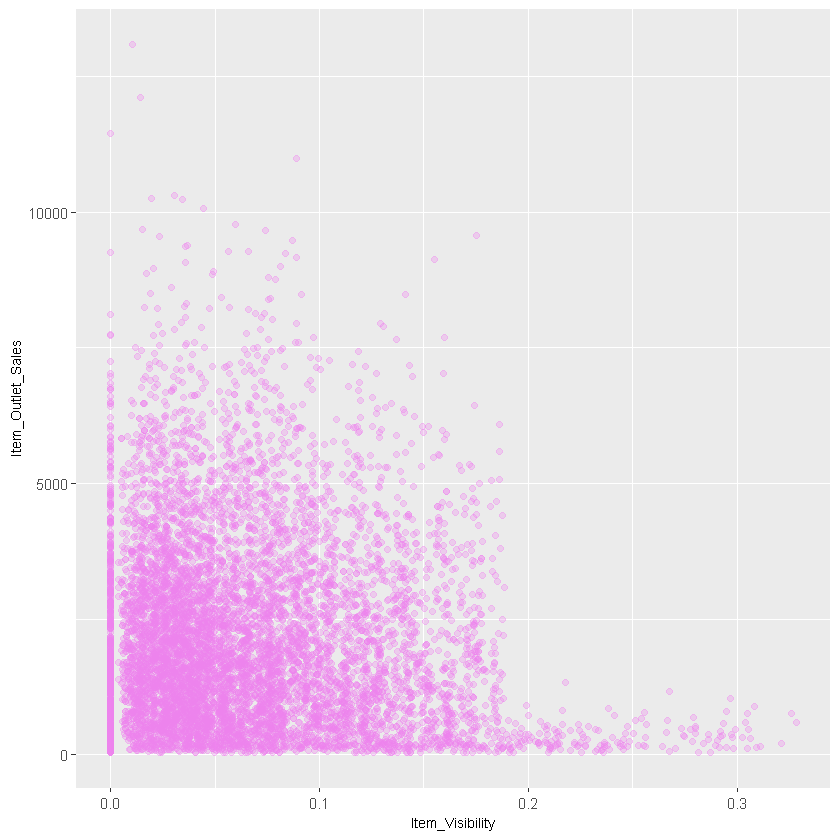

In [19]:
p10 = ggplot(train) +geom_point(aes(Item_Visibility, Item_Outlet_Sales), color = "violet", alpha= 0.3)+theme(axis.title = element_text(size = 8.5))
p10
 

Warning message:
"Removed 1463 rows containing missing values (geom_point)."

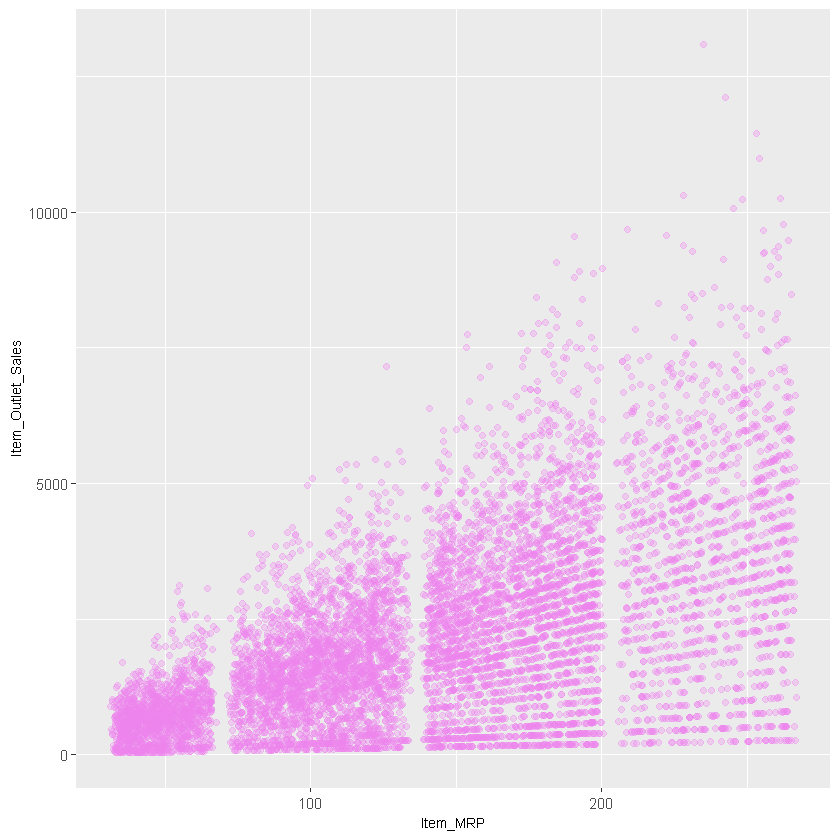

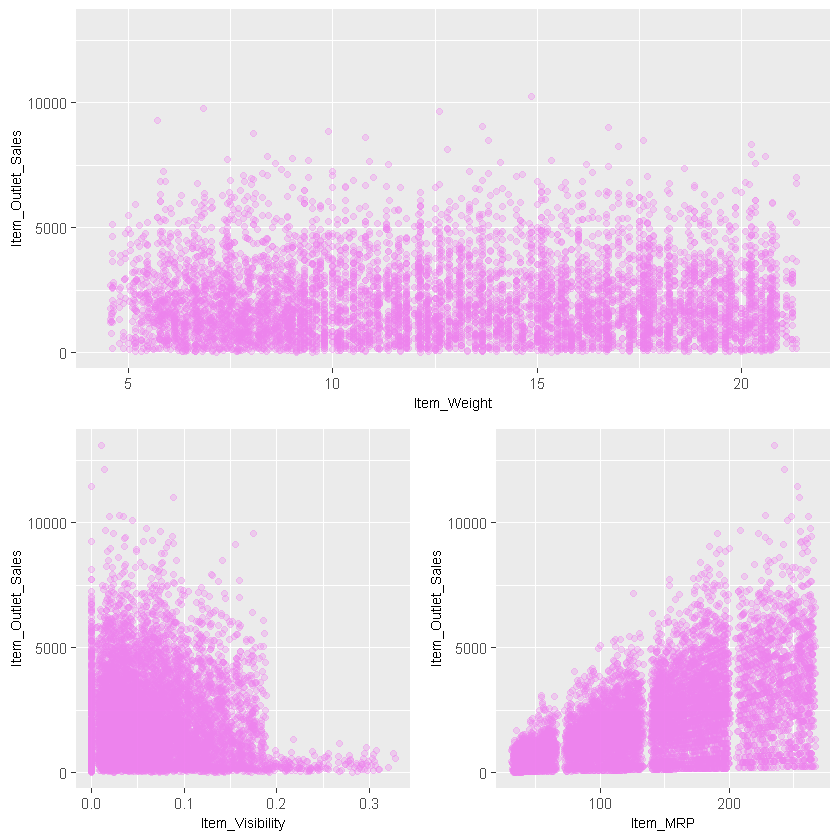

In [20]:
p11 = ggplot(train) +geom_point(aes(Item_MRP, Item_Outlet_Sales), color = "violet", alpha= 0.3)+theme(axis.title = element_text(size = 8.5))
p11
 
second_row_2 = plot_grid(p10, p11, ncol = 2)
plot_grid(p9, second_row_2, nrow = 2)

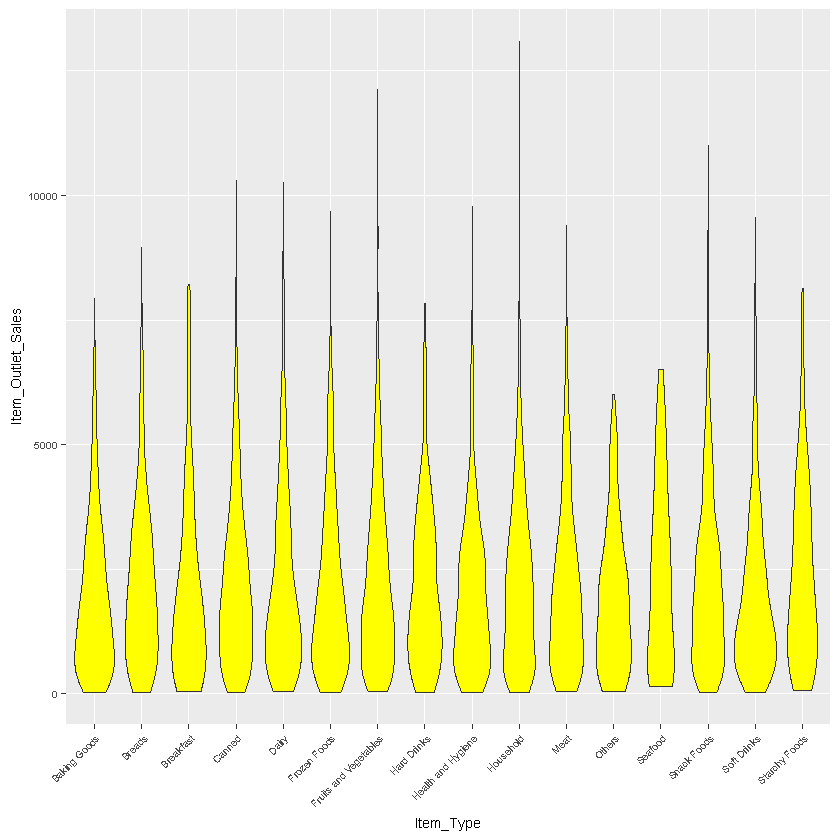

In [23]:
#Item_Outlet_Sales
p12 = ggplot(train) + 
  geom_violin(aes(Item_Type, Item_Outlet_Sales), fill = "yellow") +
  theme(axis.text.x = element_text(angle = 45, hjust = 1),
        axis.text = element_text(size = 6),
        axis.title = element_text(size = 8.5))
 
p12

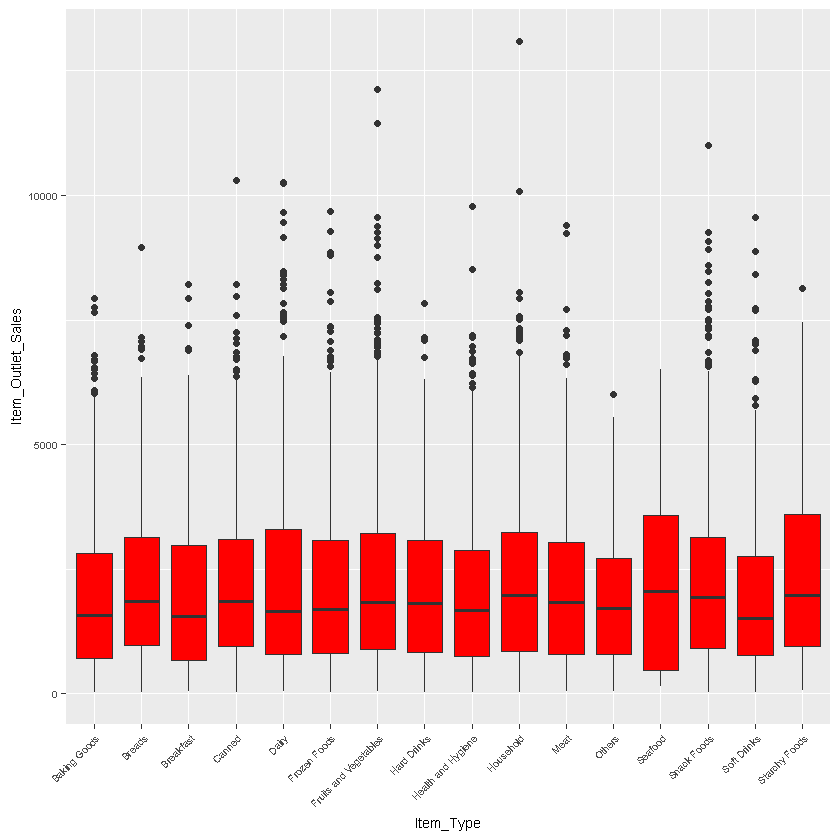

In [27]:
p12 = ggplot(train) + 
  geom_boxplot(aes(Item_Type, Item_Outlet_Sales), fill = "red") +
  theme(axis.text.x = element_text(angle = 45, hjust = 1),
        axis.text = element_text(size = 6),
        axis.title = element_text(size = 8.5))

 

p12


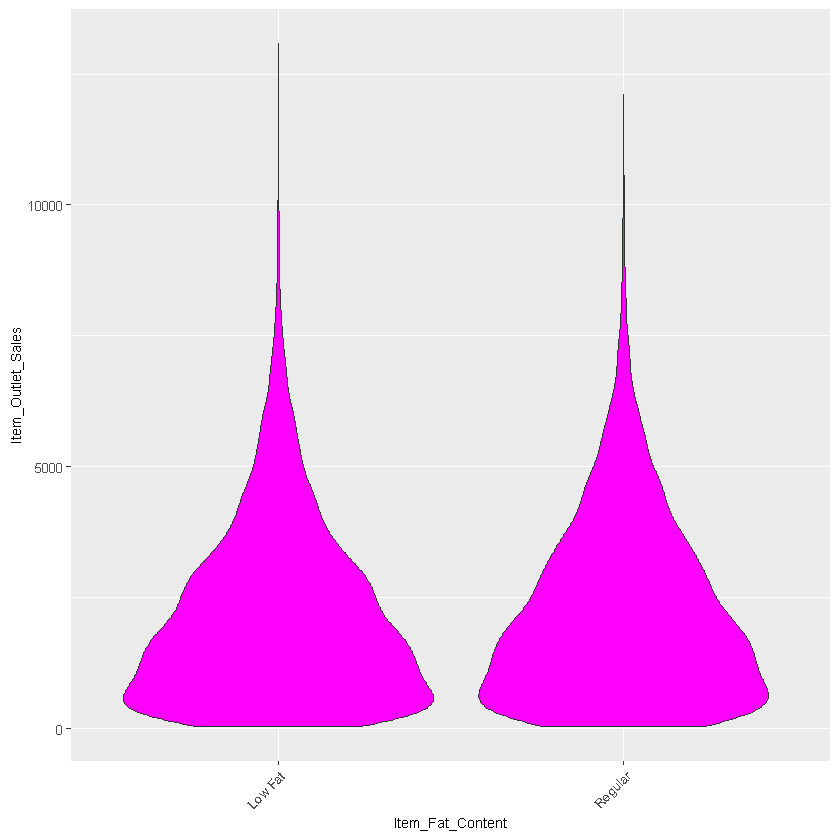

In [28]:
p13 = ggplot(train) + geom_violin(aes(Item_Fat_Content, Item_Outlet_Sales), fill = "magenta") +
  theme(axis.text.x = element_text(angle = 45, hjust = 1),
        axis.text = element_text(size = 8),
        axis.title = element_text(size = 8.5))
p13

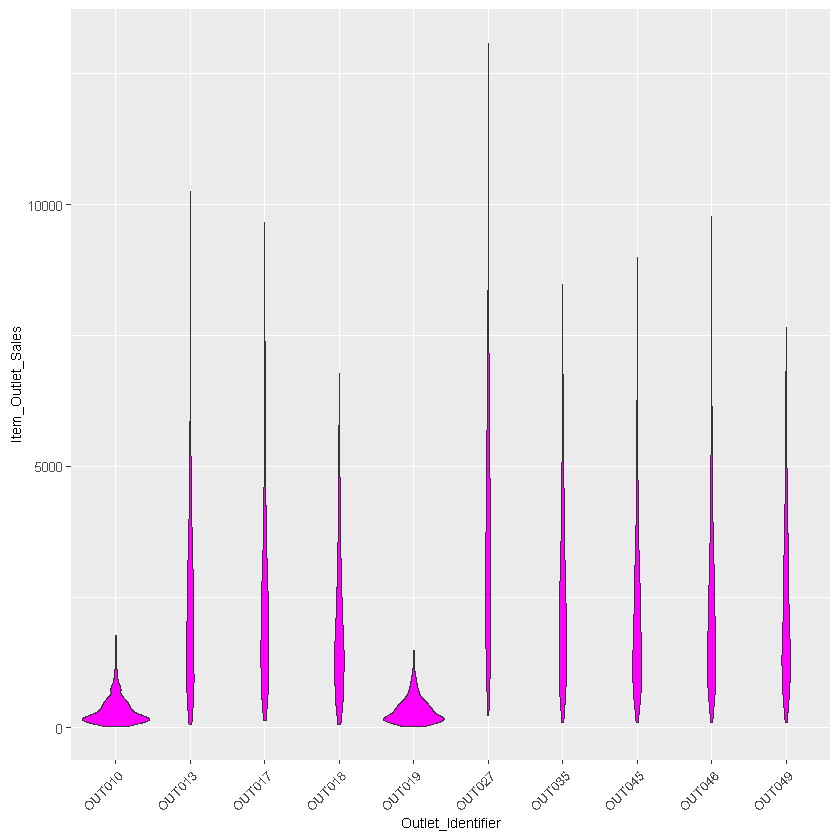

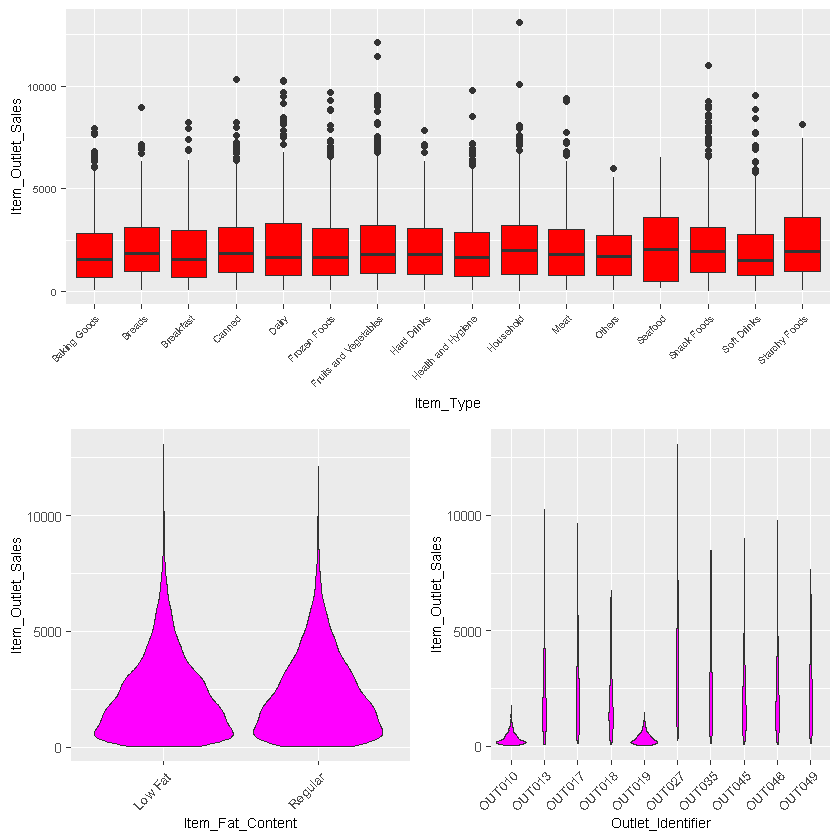

In [29]:
p14 = ggplot(train) + geom_violin(aes(Outlet_Identifier, Item_Outlet_Sales), fill = "magenta") +
  theme(axis.text.x = element_text(angle = 45, hjust = 1),
        axis.text = element_text(size = 8),
        axis.title = element_text(size = 8.5))
p14
second_row_3 = plot_grid(p13, p14, ncol = 2)
 
plot_grid(p12, second_row_3, ncol = 1)

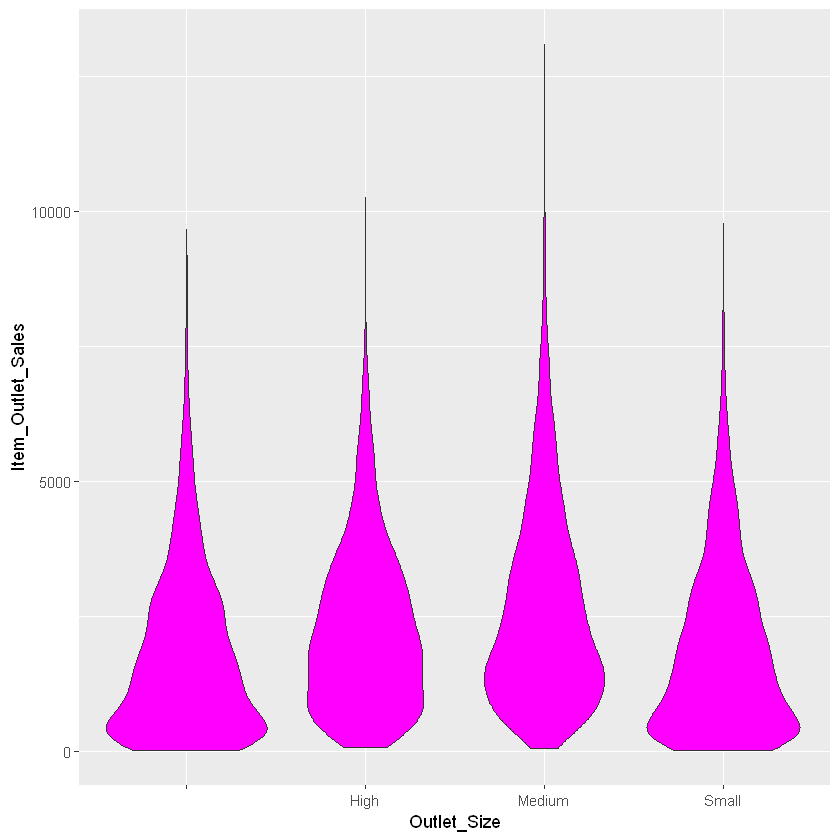

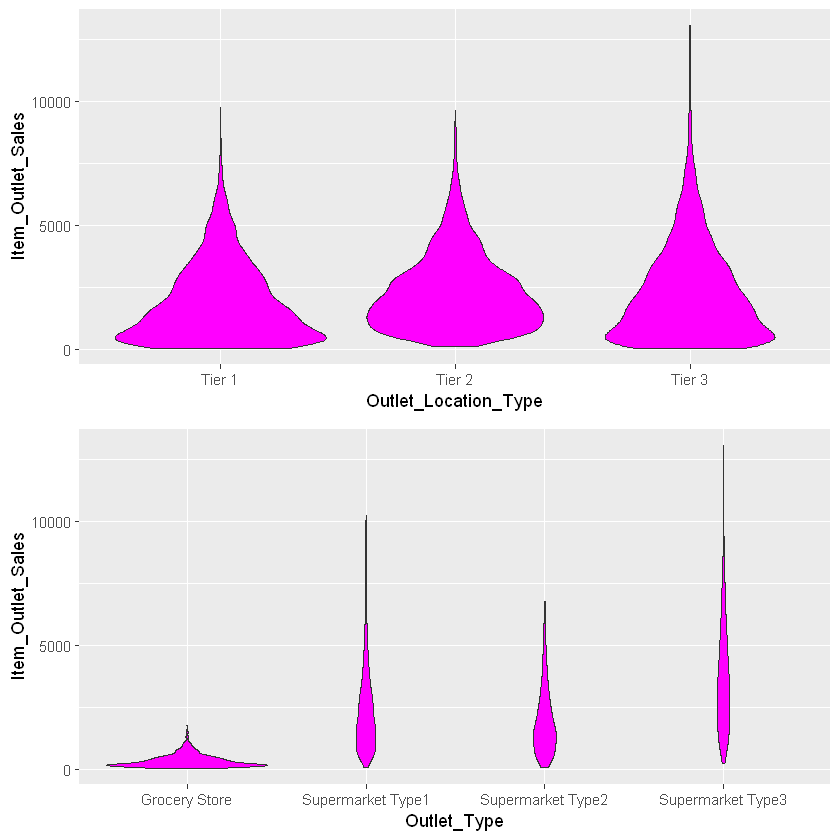

In [30]:
ggplot(train) + geom_violin(aes(Outlet_Size, Item_Outlet_Sales), fill = "magenta")
 
p15 = ggplot(train) + geom_violin(aes(Outlet_Location_Type, Item_Outlet_Sales), fill = "magenta")
 
p16 = ggplot(train) + geom_violin(aes(Outlet_Type, Item_Outlet_Sales), fill = "magenta")
 
plot_grid(p15, p16, ncol = 1)